In [2]:
%matplotlib inline

import numpy as n
import matplotlib.pyplot as p
import numpy.fft as f
import scipy.signal as sig
import copy

# Theory

In this notebook, I investigate the ues of optimal quadratic estimators on a simple band limited signal with a naive fourier transform and constant covariance. 

According to Ali 2015, we first estimate $\widehat{q}_\alpha$ as 
$$
\widehat{q}_\alpha = \frac{1}{2} x^\dagger C^{-1} Q_\alpha C^{-1} x - b_\alpha 
$$
where x is the data vector, $C$ is the covariance matrix, and $Q_\alpha$ performs the Fourier transform at the $\alpha^{th}$ k-bin. The power spectrum is determined from $\widehat{q}$ with the normalization matrix
$$
\widehat{p} = M \widehat{q}
$$
which results in $\widehat{p}$ being composed of an add-mixture of different modes
$$
\widehat{p} = W p
$$
where $W$ is the window function matrix with 
$$
W = MF
$$
where
$$
F_{\alpha \beta} = \frac{1}{2} tr\left[ C^{-1} Q_\alpha C^{-1} Q_\beta \right]
$$
If we do not weight $x$ by $C^{-1}$ but rather by an arbitrary weighting matrix which we will call $U$, we get a similar equation for $F$ with $C^{-1} \to U$. 
$$
F_{\alpha \beta} = \frac{1}{2} tr \left[ U Q_\alpha U Q_\beta \right]
$$
In this notebook, I will test the normalization matrix technique with $U$ set to the identity and employ te weights matrix described in Ali-2015 where $F$ is Cholsky-decomposed into $LL^\dagger$ with $L$ being lower triangular. Ali 2015 choose $M=D L^\dagger$ where $D$ is a diagonal matrix that ensures that the rows of $W=MF=DL^{-1}F$ sum to one. 


# Simple Case

We will consider a 20 frequency bins with 100 kHz widths between 149 and 151 MHz. The delay bins are 1/(2MHz) corresponding to $5 \times 10^{-7}$sec. I will set the middle two delay-bins to equal unity and zero outside. We see that the blackman window brings the side-lobes to a similar level as the signal. 

In [2]:
nf=22 #number of frequency bins
df=1e5 #width of each bin
npad=0#padding option, set to zero for now
fAxis=150e6-nf/2*df+n.arange(-nf/2,nf/2)*df #frequency axis centered at 150 MHz. 
delays=f.fftshift(f.fftfreq(nf,fAxis[1]-fAxis[0])) #delay axis


deltadelay=3 #number of delay sbins from zero (plus and minus) to contaminate with foregrounds
ndelays=1+2*deltadelay #number of delays (at the center of the band) to contaminate
delays2use=delays[(nf/2-deltadelay):(nf/2+deltadelay+1)] #delays to be contaminated by foregrounds
data=n.zeros(nf,dtype=complex) #data vector (equal to foregrounds+signal)
signal=n.zeros(nf,dtype=complex)#signal vector 
foregrounds=n.zeros(nf,dtype=complex)#foregrounds vector

scaleForegrounds=100.
scaleSignal=20e-3

fAmps=n.random.normal(size=(ndelays,2),scale=scaleForegrounds)#each foreground mode is a complex exponential with period of delay
                                              #gaussian random amplitude and uniform random phase
sAmps=n.random.normal(size=(nf,2),scale=scaleSignal)     #signal amplitudes are gaussian in amplitude and uniform in phase. 

powerIndex=-0.8                               #modulate foreground amplitudes by power law index. 

#populate foregrounds
for mm,delay in enumerate(delays2use):
    foregrounds+=n.cos(2*n.pi*(fAxis-fAxis[nf/2])*delay)*(fAmps[mm,0])#*(fAxis/fAxis[nf/2])**powerIndex
    foregrounds+=1j*n.sin(2*n.pi*(fAxis-fAxis[nf/2])*delay)*(fAmps[mm,1])#*(fAxis/fAxis[nf/2])**powerIndex


#populated signal
for mm,delay in enumerate(delays):
    signal+=n.cos(2*n.pi*(fAxis-fAxis[nf/2])*delay)*(sAmps[mm,0])
    signal+=1j*n.sin(2*n.pi*(fAxis-fAxis[nf/2])*delay)*(sAmps[mm,1])


#create data (foregrounds+signal)
data=foregrounds+signal



#window function
window=sig.blackmanharris(nf)
#window[:]=1.

#Apply padding, update delay axis. 
window=n.pad(window,((npad,npad)),mode='constant')
data=n.pad(data,((npad,npad)),mode='constant')
foregrounds=n.pad(foregrounds,((npad,npad)),mode='constant')
signal=n.pad(signal,((npad,npad)),mode='constant')
nf=nf+2*npad
delays=f.fftshift(f.fftfreq(nf,fAxis[1]-fAxis[0]))
fAxis=150e6-nf/2*df+n.arange(-nf/2,nf/2)*df #frequency axis centered at 150 MHz. 


#now generate a covariance matrix
covDelay=n.diag(2.*n.ones(nf)*scaleSignal**2.)

for mm in range(nf/2-deltadelay,nf/2+deltadelay+1):
    covDelay[mm,mm]+=2.*scaleForegrounds**2.
    
p.imshow(covDelay,interpolation='nearest')
p.show()
#windowX,windowY=n.meshgrid(sig.blackmanharris(nf),sig.blackmanharris(nf))
#covFrequency=n.fliplr(f.fftshift(f.ifft2(f.fftshift(covDelay*windowX*windowY))))
covFrequency=n.fliplr(f.fftshift(f.ifft2(f.fftshift(covDelay))))



fGrid,fpGrid=n.meshgrid(fAxis,fAxis)

covFrequency=scaleForegrounds**2.*2*n.sinc(2*n.pi*(fGrid-fpGrid)*delays[nf/2+deltadelay+1])#n.sin(2*n.pi*(fGrid-fpGrid)*delays[nf/2-deltadelay])/(n.pi*(fGrid-fpGrid))
covFrequency+=scaleSignal**2.*n.diag(n.ones((nf,1)))

print n.linalg.cond(covFrequency)


#straightforward windowed ffts of signal, data, and foregrounds for comparison
fsignal=f.fftshift(f.fft(f.fftshift(signal*window)))
fdata=f.fftshift(f.fft(f.fftshift(data*window)))
fforegrounds=f.fftshift(f.fft(f.fftshift(foregrounds*window)))


NameError: name 'n' is not defined

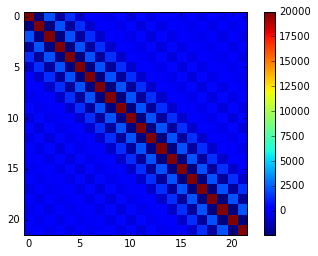

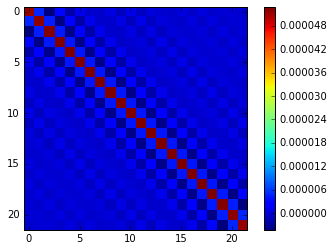

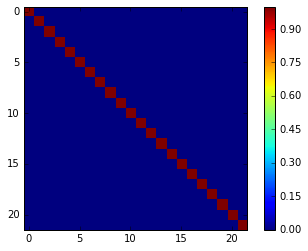

In [353]:
p.imshow(n.real(covFrequency),interpolation='nearest')
p.colorbar()
p.show()

p.imshow(n.real(covFrequencyInv),interpolation='nearest')
p.colorbar()
p.show()
p.imshow(n.abs(n.dot(covFrequency,covFrequencyInv)),interpolation='nearest')
p.colorbar()

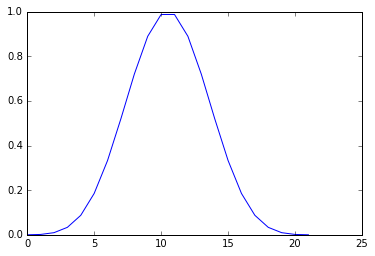

In [354]:
p.plot(window)

First we construct the $Q_\alpha$ matrices for each delay bin. We also compute unnormalized power spectra using the OQE formalism. We order data so that we have zero, than k0,-k1,k1,-k2,k2,-k3,k3 etc...

In [355]:
qMatrixFull=n.zeros((nf,nf,nf),dtype=complex) #the Qmatrix for all delay bins. the first axis is delay
                                              #ordered a-la Ali 2015 as 0,-1,1,-2,2,-3,3,... so that 
                                              #Cholskey decomposition can prevent small k -> large k 
                                              #leakage
                                              #the second and third axes are frequency and are ordered from -nf/2
                                              #to nf/2-1 with zero in the center. 
                    
fsignal_un=n.zeros(nf,dtype=complex)          #un-normalized signal (without M matrix application)
fdata_un=n.zeros(nf,dtype=complex)            #un-normalized data  (un-normalized signal+un-normalized foregrounds)
fforegrounds_un=n.zeros(nf,dtype=complex)     #un-normalized foregrounds


delayMap=n.zeros(nf,dtype=int)#index for mapping from typical indexing: 0,1,2,...nf/2-1 to
                              #Ali 2015 ordered indices 0,-1,1,-2,2,-3,3,...nf/2-1,-nf/2
delayMapI=n.zeros(nf,dtype=int)#index mapping from Ali 2015 indices 0,-1,1,-2,2,-3,3,...,nf/2-1,-nf/2 to 
                               #usual indexing: 0,1,2,3,...

for mm in range(nf/2): 
    delayMap[2*mm+1]=-mm-1           #odd indices map to negative delays with increasingly negative values
    delayMap[2*mm]=mm                #evem indices map to positive delays with increasingly positive values
    delayMapI[mm+nf/2]=2*mm          #inverse of mapping
    delayMapI[-mm-1+nf/2]=2*mm+1     #inverse of mapping
        

#for mm in range(nf):
#    delayMap[mm]=mm-nf/2
#    delayMapI[mm]=mm

    
print delayMap
print delayMapI

#now generate un-normalized signal and foregrounds
for mm,delay in enumerate(delays):
    cs=n.exp(2j*n.pi*delayMap[mm]*n.arange(-nf/2.,nf/2.)/nf) #qmatrix is the outer product of signusoids. 
                                                             #note that the delay of the sinusoid is set by
                                                             #delaymap
    #cs[:npad]=0.
    #cs[-npad:]=0.
    cs*=window
    qMatrix=n.outer((cs),n.conj(cs).T)                       #qmatrix is outer product of delay-transform
    qMatrixFull[mm,:,:]=qMatrix                              #populate qmatrixfull row
    
    
    fsignal_un[mm]=.5*n.dot(n.conj(n.dot(covFrequencyInv,signal)).T,n.dot(qMatrix,n.dot(covFrequencyInv,signal)))    #q=1/2 x W Q W x (signal)
    fforegrounds_un[mm]=.5*n.dot(n.conj(n.dot(covFrequencyInv,foregrounds)).T,n.dot(qMatrix,n.dot(covFrequencyInv,foregrounds))) #same for foregrounds
    fdata_un[mm]=fforegrounds_un[mm]+fsignal_un[mm]  #data un-normalized = foregrounds+signal un-normalized
    


[  0  -1   1  -2   2  -3   3  -4   4  -5   5  -6   6  -7   7  -8   8  -9
   9 -10  10 -11]
[21 19 17 15 13 11  9  7  5  3  1  0  2  4  6  8 10 12 14 16 18 20]


Now Compare OQE and direct fft power spectra. They are the same. This also verifies our indexing scheme.

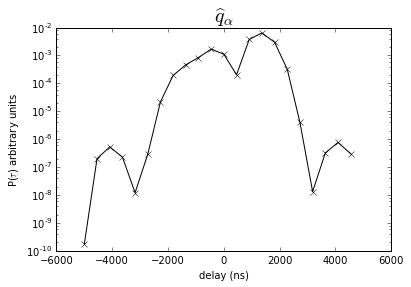

In [356]:
#plot power spectrum from windowed FT
#p.plot(delays*1e9,.5*n.abs(fdata)**2.,color='k')
#p.plot(delays*1e9,.5*n.abs(fsignal)**2.,color='r')
#p.plot(delays*1e9,.5*n.abs(fforegrounds)**2.,color='grey')

#plot power spectrum from OQE application
p.plot(delays*1e9,(n.abs(fdata_un[delayMapI])),color='k',marker='x')
#p.plot(delays*1e9,(n.abs(fsignal_un[delayMapI])),color='r',marker='x')
#p.plot(delays*1e9,(n.abs(fforegrounds_un[delayMapI])),color='grey',marker='x')
p.yscale('log')
p.title('$\widehat{q}_\\alpha$',fontsize=20)
p.xlabel('delay (ns)')
p.ylabel('P($\\tau$) arbitrary units')


Now let's construct the $F$ matrix and perform Cholsky Decomposition.

In [363]:

uMatrix=n.diag(window).astype(complex) #this is the weighting matrix 
                                       #(taking the place of the inverse covariance matrix.)
                                       #I take it to be the window function. 
uMatrix=covFrequencyInv
fMatrix=n.zeros((nf,nf),dtype=complex)
for mm in range(nf):
    for nn in range(nf):
        fMatrix[mm,nn]=.5*n.trace(n.dot(uMatrix,n.dot(qMatrixFull[mm,:,:],n.dot(uMatrix,qMatrixFull[nn,:,:]))))
lMatrix=n.linalg.cholesky(fMatrix)

dMatrix=n.zeros((nf,nf),dtype=complex)

for mm in range(nf):
    dMatrix[mm,mm]=1./n.sum(n.conj(lMatrix[:,mm]))
    
mMatrix=n.dot(dMatrix,n.linalg.inv(lMatrix))

mMatrix=n.linalg.inv(fMatrix)

fdata_n=n.dot(mMatrix,fdata_un)
fsignal_n=n.dot(mMatrix,fsignal_un)
fforegrounds_n=n.dot(mMatrix,fforegrounds_un)



In [364]:
print mMatrix.shape
print fforegrounds_un.shape

(22, 22)
(22,)


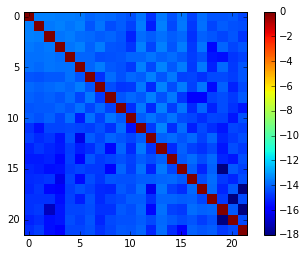

In [365]:
p.imshow(n.log10(n.abs(n.dot(mMatrix,fMatrix))),interpolation='nearest',vmin=-18,vmax=0)
p.colorbar()
p.show()

/Users/aaronew/Python/default/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


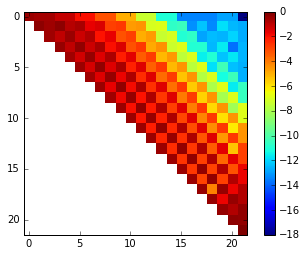

In [366]:
p.imshow(n.log10(n.abs(n.dot(dMatrix,n.conj(lMatrix).T))),interpolation='nearest',vmin=-18,vmax=0)
p.colorbar()
p.show()

Compare the normalized power spectrum $\widehat{p} = M \widehat{q}$. Things definitely don't look better...

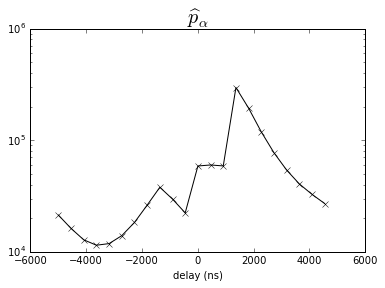

In [367]:
#p.plot(delays*1e9,n.abs(fdata_un[delayMapI]),color='k',marker='o',ls='none')
#p.plot(delays*1e9,n.abs(fsignal_un[delayMapI]),color='r',marker='o',ls='none')
#p.plot(delays*1e9,n.abs(fforegrounds_un[delayMapI]),color='grey',marker='o',ls='none')

p.plot(delays*1e9,(n.abs(fdata_n[delayMapI])),color='k',marker='x')#,ls='none')
#p.plot(delays*1e9,(n.abs(fsignal_n[delayMapI])),color='r',marker='x')#,ls='none')
#p.plot(delays*1e9,(n.abs(fforegrounds_n[delayMapI])),color='grey',marker='x')#,ls='none')
p.yscale('log')
p.xlabel('delay (ns)')
p.title('$\widehat{p}_\\alpha$',fontsize=20)



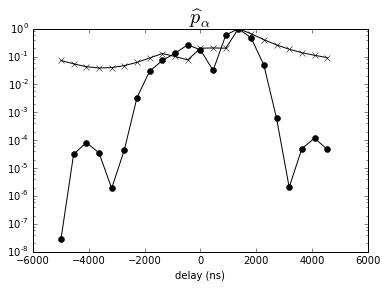

In [368]:
#p.plot(delays*1e9,n.abs(fdata_un[delayMapI]),color='k',marker='o',ls='none')
#p.plot(delays*1e9,n.abs(fsignal_un[delayMapI]),color='r',marker='o',ls='none')
#p.plot(delays*1e9,n.abs(fforegrounds_un[delayMapI]),color='grey',marker='o',ls='none')
p.plot(delays*1e9,(n.abs(fdata_un[delayMapI])/n.abs(fdata_un).max()),color='k',marker='o')#,ls='none')
p.plot(delays*1e9,(n.abs(fdata_n[delayMapI])/n.abs(fdata_n).max()),color='k',marker='x')#,ls='none')
#p.plot(delays*1e9,(n.abs(fsignal_n[delayMapI])),color='r',marker='x')#,ls='none')
#p.plot(delays*1e9,(n.abs(fforegrounds_n[delayMapI])),color='grey',marker='x')#,ls='none')
p.yscale('log')
p.xlabel('delay (ns)')
p.title('$\widehat{p}_\\alpha$',fontsize=20)




Lets check on the window function which is equal to $W=MF=DL^\dagger$ and compare to the unnormalized window function. We see that the unnormalized window function is a blackman harris window while the normalized one is a blackman with the lower k values excised. This seems sensible and I'm surprised that we are seeing as much foreground leakage as we are. 

In [369]:
wMatrix=n.dot(dMatrix,n.conj(lMatrix).T)
wMatrix=n.dot(mMatrix,fMatrix)
wMatrixActual=n.dot(mMatrix,fMatrix)
wMatrix_un=copy.copy(fMatrix)

for mm in range(nf):
    wMatrix_un[mm,:]=wMatrix_un[mm,:]/n.sum(wMatrix_un[mm,:])

(1e-16, 1.0)

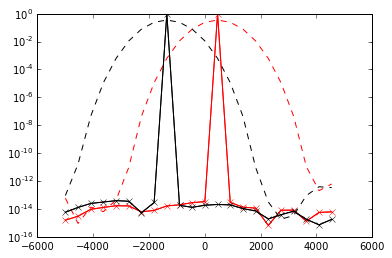

In [370]:
colors=['r','k']
for mm,nn in enumerate([2,5]):
    p.plot(delays*1e9,(n.abs(wMatrix[nn,delayMapI])),ls='-',color=colors[mm])
    p.plot(delays*1e9,(n.abs(wMatrixActual[nn,delayMapI])),ls='-',color=colors[mm],marker='x')
    p.plot(delays*1e9,(n.abs(wMatrix_un[nn,delayMapI])),ls='--',color=colors[mm])
    
    #p.axvline(delays[delayMap[nn]+nf/2]*1e9,ls='--',color=colors[mm],marker='o')
    #p.axvline(-delays[delayMap[nn]+nf/2]*1e9,ls='--',color=colors[mm],marker='o')

p.yscale('log')
p.ylim(1e-16,1e0)



In [280]:
def reorderMatrix(inputMatrix,inputMap):
    output=n.zeros_like(inputMatrix)
    for mm in range(len(inputMap)):
        for ll in range(len(inputMap)):
            nn=inputMap[mm]+nf/2
            pp=inputMap[ll]+nf/2
            output[nn,pp]=inputMatrix[mm,ll]
    return output
    

In [281]:
wMatrix_r=reorderMatrix(wMatrix,delayMap)
wMatrix_r_actual=reorderMatrix(wMatrixActual,delayMap)

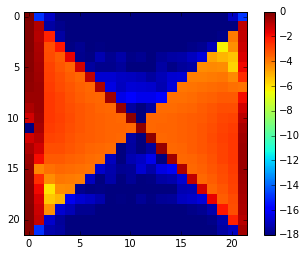

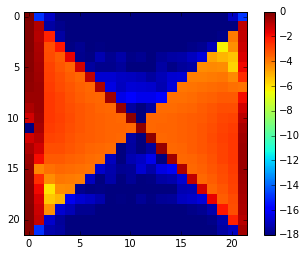

In [282]:
p.imshow(n.log10(n.abs(wMatrix_r)),interpolation='nearest',vmin=-18,vmax=0)
p.colorbar()
p.show()

p.imshow(n.log10(n.abs(wMatrix_r_actual)),interpolation='nearest',vmin=-18,vmax=0)
p.colorbar()
p.show()